In [2]:
import os
import pandas as pd
import seaborn as sns
from datetime import date
from matplotlib import pyplot
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
interesting_indices = ["NIFTY 50", "NIFTY NEXT 50", "NIFTY MIDCAP 50", "NIFTY MIDCAP 100", \
                       "NIFTY MIDCAP 150", "NIFTY SMALLCAP 50", "NIFTY SMALLCAP 100", \
                       "NIFTY SMALLCAP 250", "NIFTY MIDSMALLCAP 400", "NIFTY 100", \
                       "NIFTY 200", "NIFTY AUTO", "NIFTY BANK", "NIFTY ENERGY", \
                       "NIFTY FINANCIAL SERVICES", \
                       "NIFTY FMCG", "NIFTY IT", "NIFTY MEDIA", "NIFTY METAL", "NIFTY PHARMA", \
                       "NIFTY PSU BANK", "NIFTY REALTY", "NIFTY PRIVATE BANK", "NIFTY DIVIDEND OPPORTUNITIES 50", \
                       "NIFTY50 VALUE 20", "NIFTY100 QUALITY 30", "NIFTY50 EQUAL WEIGHT", \
                       "NIFTY100 EQUAL WEIGHT", "NIFTY100 LOW VOLATILITY 30", "NIFTY ALPHA 50", \
                       "NIFTY200 QUALITY 30", "NIFTY ALPHA LOW-VOLATILITY 30", "NIFTY200 MOMENTUM 30", \
                       "NIFTY COMMODITIES", "NIFTY INDIA CONSUMPTION", "NIFTY CPSE", "NIFTY INFRASTRUCTURE", \
                       "NIFTY MNC", "NIFTY GROWTH SECTORS 15", "NIFTY PSE", "NIFTY SERVICES SECTOR", \
                        "NIFTY100 LIQUID 15", "NIFTY MIDCAP LIQUID 15"]

# benchmark_indices = ["NIFTY 50", "NIFTY NEXT 50", "NIFTY 100", "NIFTY100 EQUAL WEIGHT", "NIFTY ALPHA 50", "NIFTY50 VALUE 20", "NIFTY MIDCAP 150"]
# benchmark_indices = ["NIFTY 50", "NIFTY NEXT 50", "NIFTY100 EQUAL WEIGHT", "NIFTY ALPHA 50", "NIFTY ALPHA LOW-VOLATILITY 30"]
benchmark_indices = ["NIFTY 50", "NIFTY ALPHA LOW-VOLATILITY 30"]

In [4]:
dfs = []
volatilities = []
sharpes = []
for index in benchmark_indices:
    file_name = f'index_data_30/{index}-last-30-years.csv'
    if os.path.exists(file_name):
        df = pd.read_csv(file_name)
        df['HistoricalDate']= pd.to_datetime(df['HistoricalDate'])
        df = df[['HistoricalDate', 'CLOSE']]
        df.rename(columns={'CLOSE': index, 'HistoricalDate': 'Date'}, inplace=True)
        df = df.set_index('Date')
        df.sort_index(inplace=True)
        df['Log_Ret'] = np.log(df[index] / df[index].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=252).std() * np.sqrt(252)
        df['Sharpe_Ratio'] = df['Log_Ret'].mean() / df['Volatility']
        df.rename(columns={'Volatility': f'{index}_V', 'Sharpe_Ratio': f'{index}_SR'}, inplace=True)
        dfs.append(df[[index]])
        volatilities.append(df[[f'{index}_V']])
        sharpes.append(df[[f'{index}_SR']])

<AxesSubplot:ylabel='Relative Return'>

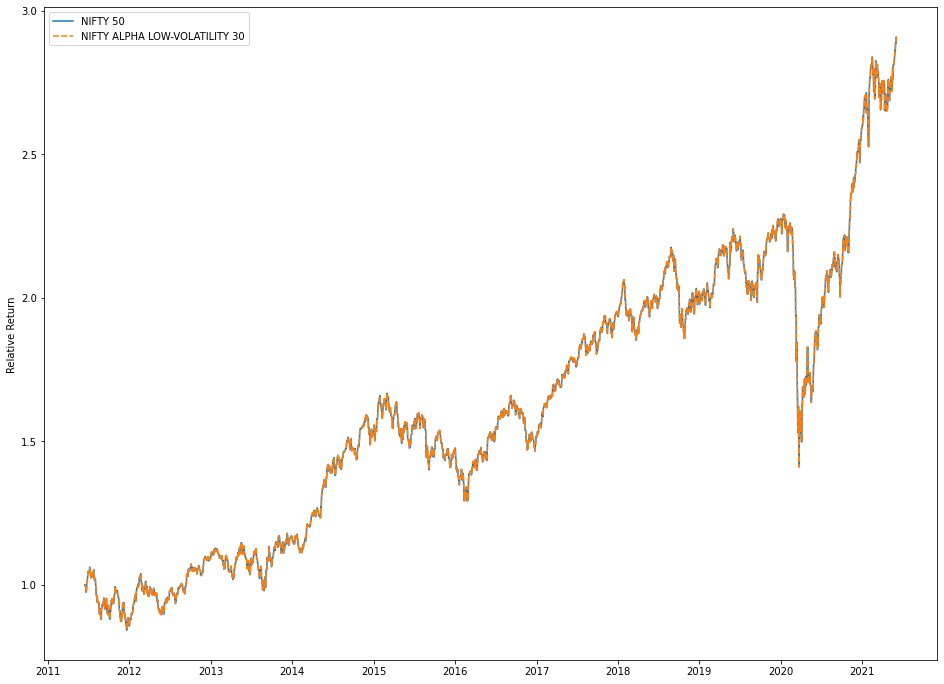

In [9]:
merged_df = pd.concat(dfs).resample('1D').mean()
merged_df.sort_index(inplace=True)
end_date = pd.Timestamp('today')
start_date = pd.Timestamp('today') + pd.Timedelta(-10*365, unit='D')
merged_df_timeslice = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]

row_df = pd.DataFrame(
            [[0.0]*len(merged_df_timeslice.columns)], \
            columns=merged_df_timeslice.columns, \
            index=[merged_df_timeslice.index.min() + pd.Timedelta(-1, unit='D')])
merged_df_timeslice = pd.concat([row_df, merged_df_timeslice.ffill().pct_change().dropna()])
merged_df_timeslice = (merged_df_timeslice + 1).cumprod()
    
a4_dims = (16, 12)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set(ylabel='Relative Return')
sns.lineplot(ax=ax, data=merged_df_timeslice)

<AxesSubplot:xlabel='Date', ylabel='Volatility over 252 days'>

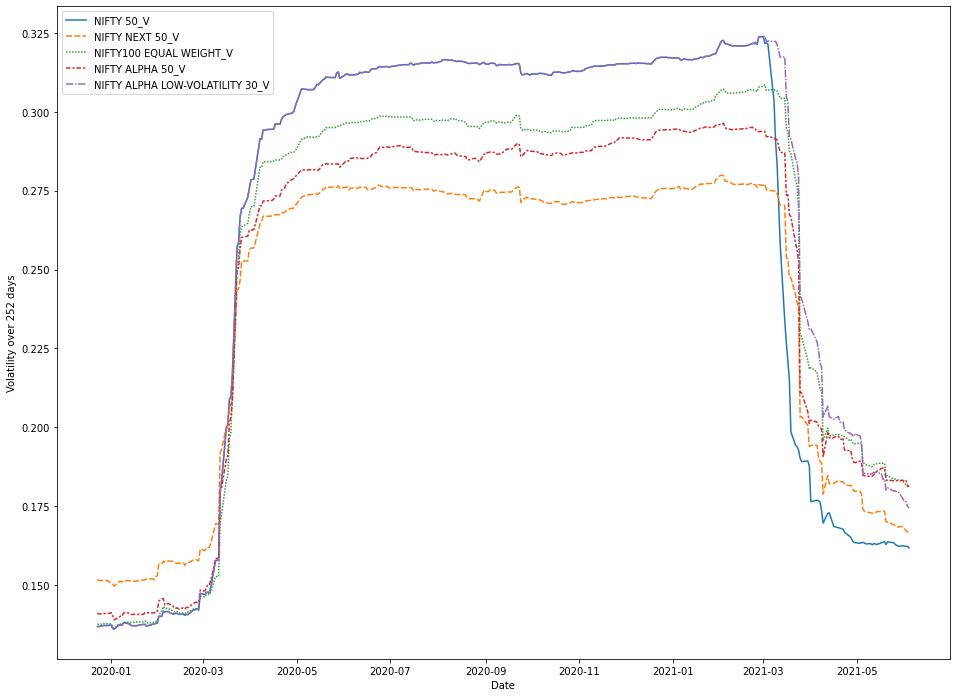

In [5]:
merged_vol = pd.concat(volatilities).resample('1D').mean()
merged_vol.sort_index(inplace=True)
end_date = pd.Timestamp('today')
start_date = pd.Timestamp('today') + pd.Timedelta(-18*30, unit='D')
merged_vol_timeslice = merged_vol[(merged_vol.index >= start_date) & (merged_vol.index <= end_date)]

a4_dims = (16, 12)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set(ylabel='Volatility over 252 days')
sns.lineplot(ax=ax, data=merged_vol_timeslice)

<AxesSubplot:xlabel='Date', ylabel='Rolling 5y relative returns'>

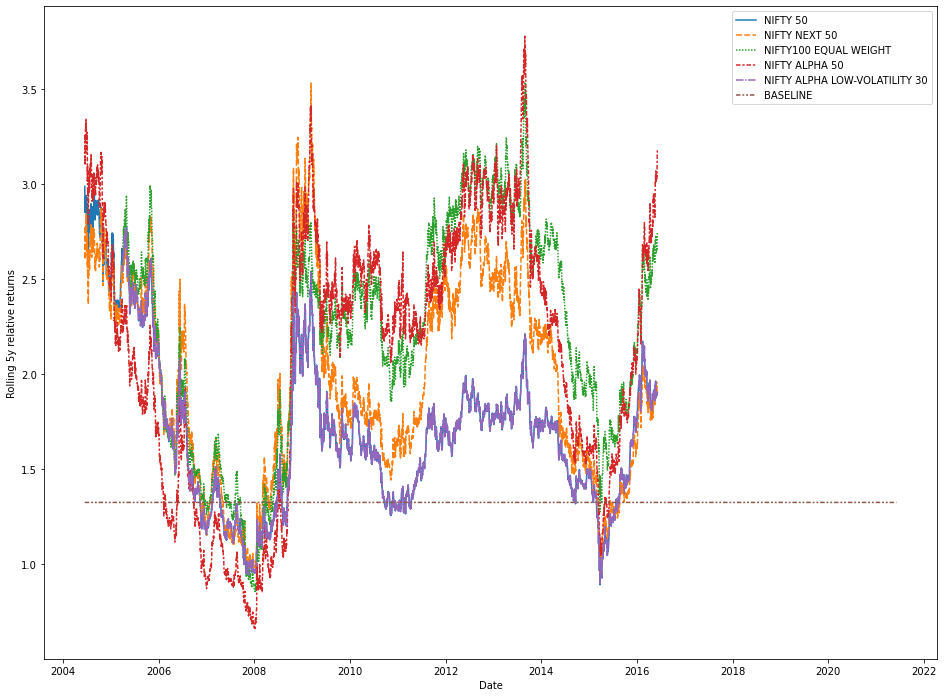

In [6]:
end_date = pd.Timestamp('today')
start_date = pd.Timestamp('today') + pd.Timedelta(-365*17, unit='D')
rolling_time_slice = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)].ffill()
years = 5
time_period = years*365
rolling_time_slice.loc[:, 'BASELINE'] = (1.058)**years

for column in merged_df.columns:
    rolling_time_slice.loc[:, column] = (rolling_time_slice[column].shift(-time_period)  / rolling_time_slice[column])
    
a4_dims = (16, 12)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set(ylabel=f'Rolling {years}y relative returns')
sns.lineplot(ax=ax, data=rolling_time_slice)

<AxesSubplot:xlabel='Date', ylabel='Sharpe ratio over 252 days'>

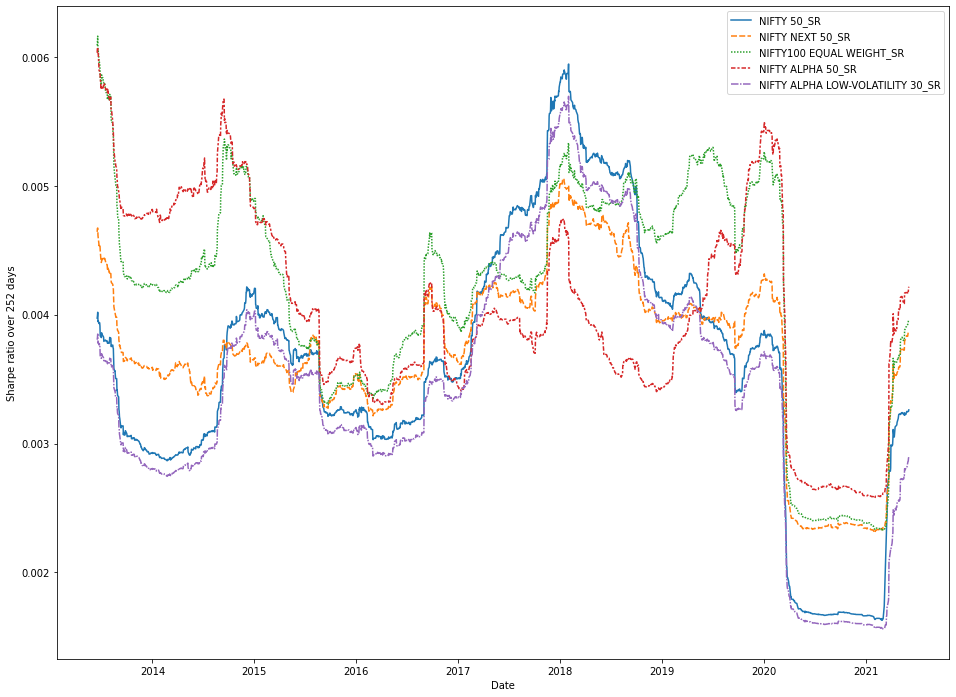

In [7]:
merged_vol = pd.concat(sharpes).resample('1D').mean()
merged_vol.sort_index(inplace=True)
end_date = pd.Timestamp('today')
start_date = pd.Timestamp('today') + pd.Timedelta(-8*365, unit='D')
merged_vol_timeslice = merged_vol[(merged_vol.index >= start_date) & (merged_vol.index <= end_date)]

a4_dims = (16, 12)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set(ylabel=f'Sharpe ratio over 252 days')
sns.lineplot(ax=ax, data=merged_vol_timeslice)

In [8]:
import glob
all_files = glob.glob("volumes/*.csv")
cols = ['Index Name', 'Index Date', 'Volume', 'Turnover (Rs. Cr.)', 'P/E', 'P/B', 'Div Yield']

li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)[cols]
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame["Index Date"] = pd.to_datetime(frame["Index Date"])
frame = frame.set_index("Index Date")
frame.sort_index(inplace=True)
for col in cols[2:]:
    frame[col] = frame[col].str.replace('-','0').replace('','0').replace(' ','0').fillna(0).astype('string')
    frame[col] = frame[col].astype('float')

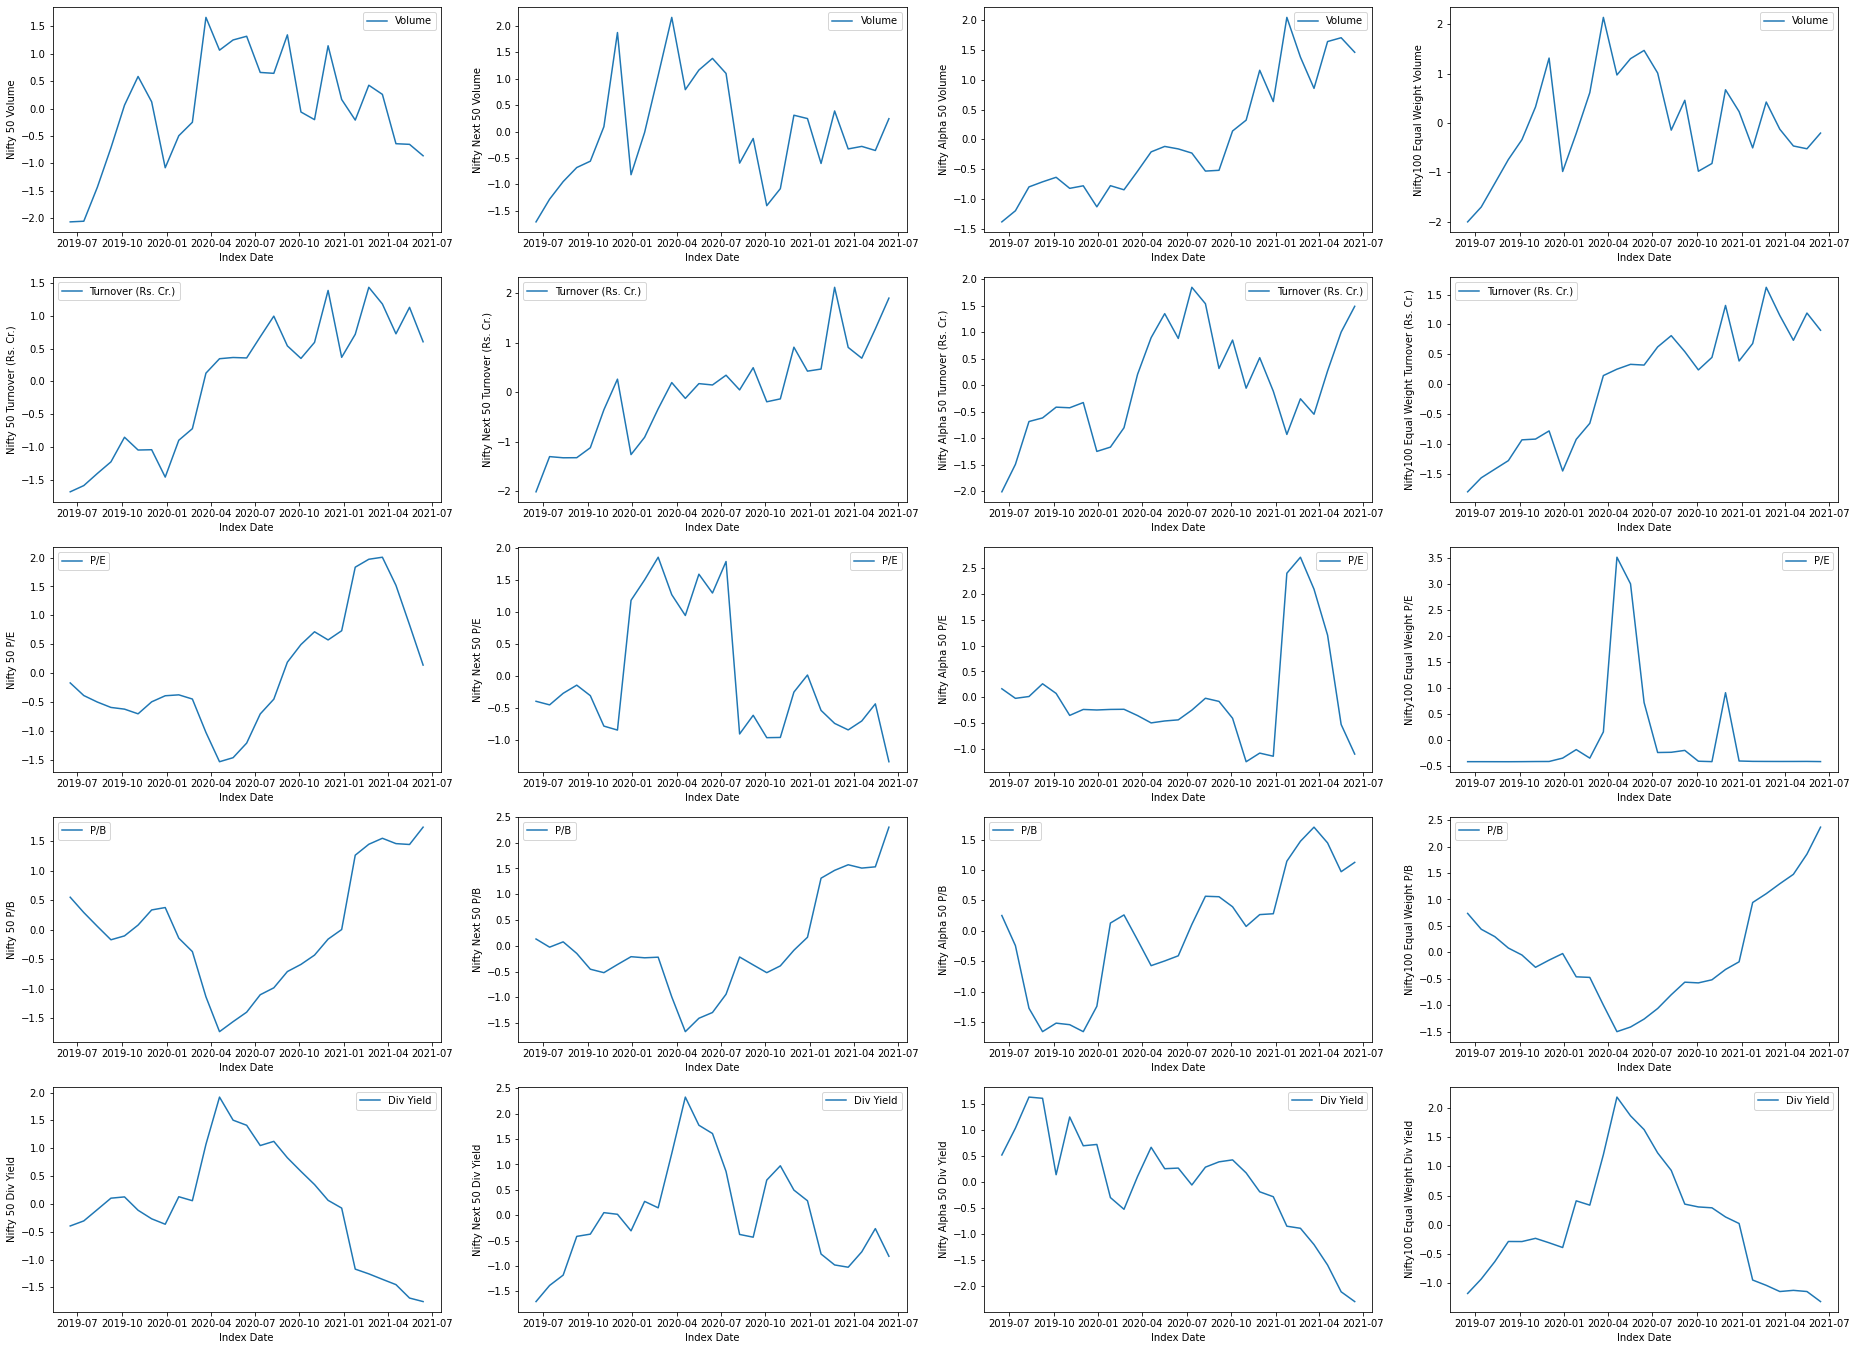

In [9]:
a4_dims = (32, 24)
index = ["Nifty 50", "Nifty Next 50", "Nifty Alpha 50", "Nifty100 Equal Weight"]
fig, axis = pyplot.subplots(nrows=5, ncols=len(index), figsize=a4_dims)
end_date = pd.Timestamp('today')
start_date = pd.Timestamp('today') + pd.Timedelta(-2*365, unit='D')

for i, col_int in enumerate(cols[2:]):
    for j, idx in enumerate(index):
        temp_df = frame[frame['Index Name'] == idx][[col_int]]
        temp_df_fil = temp_df[(temp_df.index >= start_date) & (temp_df.index <= end_date)]

        temp_df_fil = temp_df_fil.resample('4W').mean()

        mean = temp_df_fil[col_int].mean()
        std = temp_df_fil[col_int].std()
        temp_df_fil.loc[:, col_int] = (temp_df_fil[col_int] - mean)  / std

        axis[i][j].set(ylabel=f'{idx} {col_int}')
        sns.lineplot(ax=axis[i][j], data=temp_df_fil)

In [10]:
[x for x in frame['Index Name'].unique().tolist() if 'nifty' in x.lower()]

['NIFTY Midcap 50',
 'S&P CNX Nifty Dividend',
 'CNX Nifty Junior',
 'S&P CNX Nifty Shariah',
 'S&P CNX Nifty',
 'CNX Nifty Shariah',
 'CNX Nifty',
 'CNX Nifty Dividend',
 'Nifty Smallcap 50',
 'Nifty Aditya Birla Group',
 'Nifty Mahindra Group',
 'Nifty Private Bank',
 'Nifty Full Midcap 100',
 'Nifty50 PR 2x Leverage',
 'Nifty50 PR 1x Inverse',
 'Nifty50 TR 2x Leverage',
 'Nifty Growth Sectors 15',
 'Nifty Quality 30',
 'Nifty Full Smallcap 100',
 'Nifty MidSmallcap 400',
 'Nifty Tata Group',
 'Nifty Tata Group 25% Cap',
 'Nifty Shariah 25',
 'Nifty 50 Futures TR Index',
 'Nifty 8-13 yr G-Sec',
 'Nifty 10 yr Benchmark G-Sec',
 'Nifty 10 yr Benchmark G-Sec (Clean Price)',
 'Nifty 4-8 yr G-Sec Index',
 'Nifty 11-15 yr G-Sec Index',
 'Nifty 15 yr and above G-Sec Index',
 'Nifty Composite G-sec Index',
 'Nifty 1D Rate Index',
 'Nifty Smallcap 250',
 'Nifty 50 Futures Index',
 'Nifty Midcap Liquid 15',
 'Nifty CPSE',
 'Nifty IT',
 'Nifty FMCG',
 'Nifty Financial Services',
 'Nifty Energy'